In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

In [2]:
# Load HR image and simulate LR by degradation
def load_and_degrade(hr_path):
    if not os.path.exists(hr_path):
        raise FileNotFoundError("HR image not found.")

    hr = cv2.imread(hr_path)
    hr = cv2.cvtColor(hr, cv2.COLOR_BGR2RGB)
    hr = cv2.resize(hr, (512, 512))
    hr_norm = hr.astype('float32') / 255.0

    # Degrade: blur + downsample + upsample
    blurred = cv2.GaussianBlur(hr, (7, 7), 1.5)
    lr = cv2.resize(blurred, (256, 256), interpolation=cv2.INTER_AREA)
    lr_up = cv2.resize(lr, (512, 512), interpolation=cv2.INTER_CUBIC)
    lr_up = lr_up.astype('float32') / 255.0

    return lr_up, hr_norm, hr  # normalized LR, normalized HR, original HR uint8


In [1]:
# Patch extraction with same size
def extract_patches(lr_img, hr_img, patch_size=32, stride=16):
    lr_patches, hr_patches = [], []
    for i in range(0, lr_img.shape[0] - patch_size + 1, stride):
        for j in range(0, lr_img.shape[1] - patch_size + 1, stride):
            lr_patch = lr_img[i:i+patch_size, j:j+patch_size]
            hr_patch = hr_img[i:i+patch_size, j:j+patch_size]
            lr_patches.append(lr_patch)
            hr_patches.append(hr_patch)
    return np.array(lr_patches), np.array(hr_patches)

In [4]:
# SRCNN model definition
def build_srcnn():
    model = Sequential([
        Conv2D(64, (9, 9), activation='relu', padding='same', input_shape=(32, 32, 3)),
        Conv2D(32, (1, 1), activation='relu', padding='same'),
        Conv2D(3, (5, 5), activation='linear', padding='same')
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

In [5]:
# Evaluate with PSNR and SSIM
def evaluate(sr_img, gt_img):
    psnr_score = psnr(gt_img, sr_img, data_range=1.0)
    ssim_score = ssim(gt_img, sr_img, data_range=1.0, channel_axis=-1)
    return psnr_score, ssim_score

In [6]:
# Deep feature difference
def deep_feature_distance(img1, img2):
    vgg = VGG16(weights='imagenet', include_top=False, input_shape=(512, 512, 3))
    model_feat = Model(inputs=vgg.input, outputs=vgg.get_layer('block3_conv3').output)
    f1 = model_feat.predict(np.expand_dims(img1, 0))[0]
    f2 = model_feat.predict(np.expand_dims(img2, 0))[0]
    return np.mean((f1 - f2) ** 2)

In [7]:
# === Run pipeline ===
hr_path = "image2.png"
lr_up, hr_norm, hr_uint8 = load_and_degrade(hr_path)

In [8]:
# Extract patches
lr_patches, hr_patches = extract_patches(lr_up, hr_norm, patch_size=32, stride=16)
print(f"Extracted {len(lr_patches)} patches.")

Extracted 961 patches.


In [9]:
# Build and train model
model = build_srcnn()
model.fit(lr_patches, hr_patches, batch_size=8, epochs=5)

Epoch 1/5


C:\Users\Admin\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0137    
Epoch 2/5
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0033 
Epoch 3/5
121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0026 
Epoch 4/5
121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0023 
Epoch 5/5
121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0025 


In [10]:
# Predict full SR image from LR upsampled
sr_full = model.predict(np.expand_dims(lr_up, 0))[0]
sr_full = np.clip(sr_full, 0, 1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


In [11]:
# Evaluate
psnr_val, ssim_val = evaluate(sr_full, hr_norm)
feature_dist = deep_feature_distance(hr_norm, sr_full)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


In [12]:
print(f"PSNR: {psnr_val:.2f}")
print(f"SSIM: {ssim_val:.4f}")
print(f"Deep Feature Distance: {feature_dist:.6f}")

PSNR: 27.79
SSIM: 0.8720
Deep Feature Distance: 6.928054


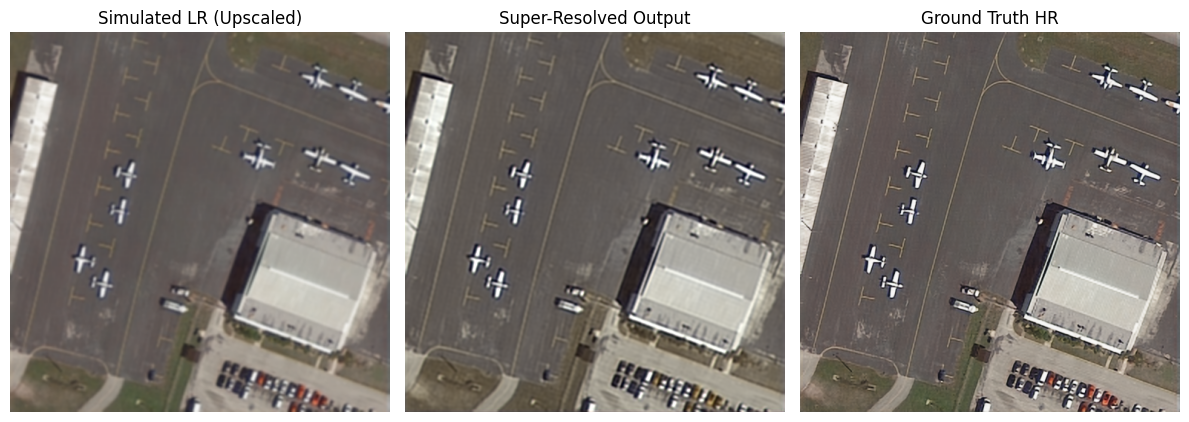

In [13]:
# Visualization
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.title("Simulated LR (Upscaled)")
plt.imshow(lr_up)
plt.axis('off')


plt.subplot(1, 3, 2)
plt.title("Super-Resolved Output")
plt.imshow(sr_full)
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Ground Truth HR")
plt.imshow(hr_uint8)
plt.axis('off')
plt.tight_layout()
plt.show()

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(lr_patches, hr_patches, test_size=0.2, random_state=42)
model = build_srcnn()
model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=8, epochs=5)

Epoch 1/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0095 - val_loss: 0.0042
Epoch 2/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0033 - val_loss: 0.0031
Epoch 3/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0027 - val_loss: 0.0026
Epoch 4/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0026 - val_loss: 0.0024
Epoch 5/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0021 - val_loss: 0.0022


In [15]:
# Function to degrade the HR image (simulate LR with blur + downsampling + upsampling)
def degrade(hr_img, sigma):
    blurred = cv2.GaussianBlur(hr_img, (7, 7), sigma)
    lr = cv2.resize(blurred, (256, 256), interpolation=cv2.INTER_AREA)
    upscaled = cv2.resize(lr, (512, 512), interpolation=cv2.INTER_CUBIC)
    return upscaled.astype('float32') / 255.0


In [16]:
# === Load and normalize HR image ===
import cv2
import numpy as np

hr_path = "image2.png"
hr = cv2.imread(hr_path)
hr = cv2.cvtColor(hr, cv2.COLOR_BGR2RGB)
hr = cv2.resize(hr, (512, 512))
hr_norm = hr.astype('float32') / 255.0


In [17]:
def degrade(hr_img, sigma):
    blurred = cv2.GaussianBlur(hr_img, (7, 7), sigma)
    lr = cv2.resize(blurred, (256, 256), interpolation=cv2.INTER_AREA)
    upscaled = cv2.resize(lr, (512, 512), interpolation=cv2.INTER_CUBIC)
    return upscaled.astype('float32') / 255.0


In [18]:
sigmas = [0.5, 1.0, 1.5, 2.0, 2.5]
psnr_scores = []
ssim_scores = []
vgg_dists = []

for sigma in sigmas:
    degraded = degrade(hr, sigma)
    sr = model.predict(np.expand_dims(degraded, 0))[0]
    sr = np.clip(sr, 0, 1)

    psnr_val = psnr(hr_norm, sr, data_range=1.0)
    ssim_val = ssim(hr_norm, sr, data_range=1.0, channel_axis=-1)
    vgg_dist = deep_feature_distance(hr_norm, sr)

    psnr_scores.append(psnr_val)
    ssim_scores.append(ssim_val)
    vgg_dists.append(vgg_dist)

    print(f"Sigma={sigma} | PSNR={psnr_val:.2f}, SSIM={ssim_val:.4f}, VGG Dist={vgg_dist:.6f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
Sigma=0.5 | PSNR=27.81, SSIM=0.8885, VGG Dist=6.694045
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
Sigma=1.0 | PSNR=28.79, SSIM=0.9005, VGG Dist=5.514500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
Sigma=1.5 | PSNR=27.58, SSIM=0.8690, VGG Dist=7.197217
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
Sigma=2.0 | PSNR=26.15, SSIM=0.8247, VGG Dist=10.229489
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
Sigma=2.5 | PSNR=25.32, SSIM=0.7929, VGG Dist=12.422957


In [19]:
from scipy.stats import spearmanr, pearsonr

# PSNR vs VGG
sp_corr, _ = spearmanr(psnr_scores, vgg_dists)
pr_corr, _ = pearsonr(psnr_scores, vgg_dists)

print(f"Spearman Correlation (PSNR vs VGG): {sp_corr:.4f}")
print(f"Pearson Correlation (PSNR vs VGG): {pr_corr:.4f}")


Spearman Correlation (PSNR vs VGG): -1.0000
Pearson Correlation (PSNR vs VGG): -0.9911


In [20]:
# Estimate blur kernel: optional, complex. Can use a placeholder for now.
# Registration example using ORB
def register_images(img1, img2):
    orb = cv2.ORB_create(500)
    kp1, des1 = orb.detectAndCompute(cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY), None)
    kp2, des2 = orb.detectAndCompute(cv2.cvtColor(img2, cv2.COLOR_RGB2GRAY), None)

    matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = matcher.match(des1, des2)

    src_pts = np.float32([kp1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)

    M, _ = cv2.estimateAffinePartial2D(src_pts, dst_pts)
    registered = cv2.warpAffine(img2, M, (img2.shape[1], img2.shape[0]))
    return registered


In [21]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
import numpy as np

# Define a function to extract deep features and compute perceptual distance
def deep_feature_distance(img1, img2):
    vgg = VGG16(weights='imagenet', include_top=False, input_shape=(512, 512, 3))
    model_feat = Model(inputs=vgg.input, outputs=vgg.get_layer('block3_conv3').output)
    
    f1 = model_feat.predict(np.expand_dims(img1, 0), verbose=0)[0]
    f2 = model_feat.predict(np.expand_dims(img2, 0), verbose=0)[0]
    
    return np.mean((f1 - f2) ** 2)


In [22]:
psnr_scores = []
ssim_scores = []
vgg_dists = []

for sigma in sigmas:
    degraded = degrade(hr, sigma)
    sr = model.predict(np.expand_dims(degraded, 0))[0]
    sr = np.clip(sr, 0, 1)

    psnr_val = psnr(hr_norm, sr, data_range=1.0)
    ssim_val = ssim(hr_norm, sr, data_range=1.0, channel_axis=-1)
    vgg_dist = deep_feature_distance(hr_norm, sr)

    psnr_scores.append(psnr_val)
    ssim_scores.append(ssim_val)
    vgg_dists.append(vgg_dist)

    print(f"Sigma={sigma} | PSNR={psnr_val:.2f}, SSIM={ssim_val:.4f}, VGG Distance={vgg_dist:.6f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Sigma=0.5 | PSNR=27.81, SSIM=0.8885, VGG Distance=6.694045
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Sigma=1.0 | PSNR=28.79, SSIM=0.9005, VGG Distance=5.514500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Sigma=1.5 | PSNR=27.58, SSIM=0.8690, VGG Distance=7.197217
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Sigma=2.0 | PSNR=26.15, SSIM=0.8247, VGG Distance=10.229489
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Sigma=2.5 | PSNR=25.32, SSIM=0.7929, VGG Distance=12.422957


In [23]:
from scipy.stats import spearmanr, pearsonr

sp_corr, _ = spearmanr(psnr_scores, vgg_dists)
pr_corr, _ = pearsonr(psnr_scores, vgg_dists)

print(f"Spearman Correlation (PSNR vs VGG): {sp_corr:.4f}")
print(f"Pearson Correlation (PSNR vs VGG): {pr_corr:.4f}")


Spearman Correlation (PSNR vs VGG): -1.0000
Pearson Correlation (PSNR vs VGG): -0.9911


Sigma=0.5 | PSNR=8.73, SSIM=0.2105, VGG Score=30.830910
Sigma=1.0 | PSNR=8.72, SSIM=0.2108, VGG Score=31.834618
Sigma=1.5 | PSNR=8.72, SSIM=0.2100, VGG Score=32.752666
Sigma=2.0 | PSNR=8.71, SSIM=0.2091, VGG Score=33.272892
Sigma=2.5 | PSNR=8.71, SSIM=0.2086, VGG Score=33.528534

--- Correlation (Blind vs GT) ---
Spearman (PSNR vs VGG): -1.0000
Pearson  (PSNR vs VGG): -0.9992
Spearman (SSIM vs VGG): -0.9000
Pearson  (SSIM vs VGG): -0.8550


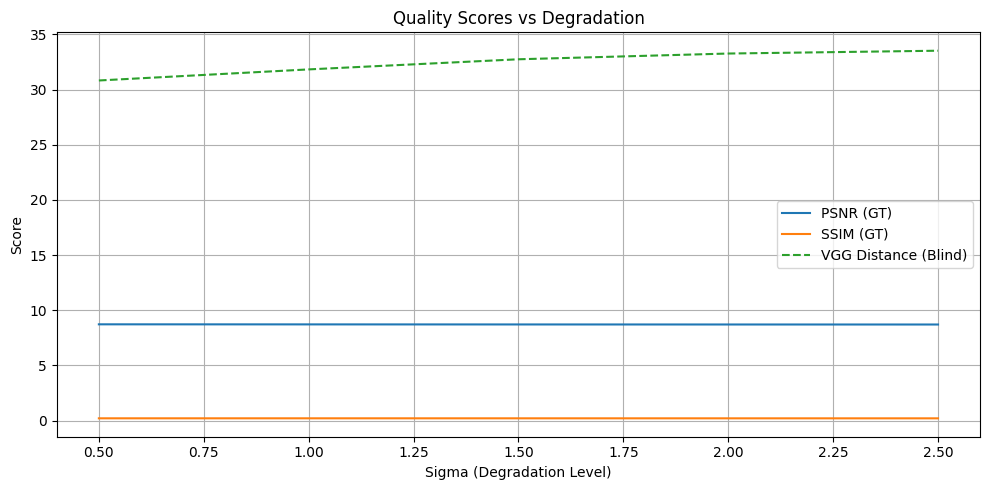

In [24]:
hr_path = "image2.png"
hr = cv2.imread(hr_path)
hr = cv2.cvtColor(hr, cv2.COLOR_BGR2RGB)
hr = cv2.resize(hr, (512, 512))
hr_norm = hr.astype('float32') / 255.0

# === Degradation function ===
def degrade(hr_img, sigma):
    blurred = cv2.GaussianBlur(hr_img, (7, 7), sigma)
    lr = cv2.resize(blurred, (256, 256), interpolation=cv2.INTER_AREA)
    upscaled = cv2.resize(lr, (512, 512), interpolation=cv2.INTER_CUBIC)
    return upscaled.astype('float32') / 255.0

# === Build SRCNN Model ===
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D

def build_srcnn():
    model = Sequential([
        Conv2D(64, (9, 9), activation='relu', padding='same', input_shape=(512, 512, 3)),
        Conv2D(32, (1, 1), activation='relu', padding='same'),
        Conv2D(3, (5, 5), activation='linear', padding='same')
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

# === Load pre-trained SRCNN or train quickly ===
model = build_srcnn()
# For demo, train quickly on synthetic pair
lr_demo = degrade(hr, sigma=1.5)
model.fit(np.expand_dims(lr_demo, 0), np.expand_dims(hr_norm, 0), epochs=1, verbose=0)

# === VGG Deep Feature Distance Function ===
def deep_feature_distance(img1, img2):
    vgg = VGG16(weights='imagenet', include_top=False, input_shape=(512, 512, 3))
    model_feat = Model(inputs=vgg.input, outputs=vgg.get_layer('block3_conv3').output)
    
    f1 = model_feat.predict(np.expand_dims(img1, 0), verbose=0)[0]
    f2 = model_feat.predict(np.expand_dims(img2, 0), verbose=0)[0]
    
    return np.mean((f1 - f2) ** 2)

# === Evaluate on different degradations (simulating quality levels) ===
sigmas = [0.5, 1.0, 1.5, 2.0, 2.5]
psnr_scores = []
ssim_scores = []
vgg_scores = []

for sigma in sigmas:
    degraded = degrade(hr, sigma)
    sr = model.predict(np.expand_dims(degraded, 0), verbose=0)[0]
    sr = np.clip(sr, 0, 1)

    # GT Scores (full reference)
    psnr_val = psnr(hr_norm, sr, data_range=1.0)
    ssim_val = ssim(hr_norm, sr, data_range=1.0, channel_axis=-1)

    # Blind Prediction (reduced reference)
    vgg_score = deep_feature_distance(hr_norm, sr)

    # Store
    psnr_scores.append(psnr_val)
    ssim_scores.append(ssim_val)
    vgg_scores.append(vgg_score)

    print(f"Sigma={sigma:.1f} | PSNR={psnr_val:.2f}, SSIM={ssim_val:.4f}, VGG Score={vgg_score:.6f}")

# === Correlation Analysis ===
sp_corr_psnr, _ = spearmanr(psnr_scores, vgg_scores)
pr_corr_psnr, _ = pearsonr(psnr_scores, vgg_scores)

sp_corr_ssim, _ = spearmanr(ssim_scores, vgg_scores)
pr_corr_ssim, _ = pearsonr(ssim_scores, vgg_scores)

print("\n--- Correlation (Blind vs GT) ---")
print(f"Spearman (PSNR vs VGG): {sp_corr_psnr:.4f}")
print(f"Pearson  (PSNR vs VGG): {pr_corr_psnr:.4f}")
print(f"Spearman (SSIM vs VGG): {sp_corr_ssim:.4f}")
print(f"Pearson  (SSIM vs VGG): {pr_corr_ssim:.4f}")

# === Optional: Plot Quality vs Sigma ===
plt.figure(figsize=(10, 5))
plt.plot(sigmas, psnr_scores, label="PSNR (GT)")
plt.plot(sigmas, ssim_scores, label="SSIM (GT)")
plt.plot(sigmas, vgg_scores, label="VGG Distance (Blind)", linestyle='--')
plt.xlabel("Sigma (Degradation Level)")
plt.ylabel("Score")
plt.title("Quality Scores vs Degradation")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [25]:
def register_images(img1, img2):
    orb = cv2.ORB_create(500)
    kp1, des1 = orb.detectAndCompute(cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY), None)
    kp2, des2 = orb.detectAndCompute(cv2.cvtColor(img2, cv2.COLOR_RGB2GRAY), None)

    matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = matcher.match(des1, des2)

    if len(matches) < 4:
        raise ValueError("Not enough matches found for registration.")

    src_pts = np.float32([kp1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)

    M, _ = cv2.estimateAffinePartial2D(src_pts, dst_pts)
    registered = cv2.warpAffine(img2, M, (img2.shape[1], img2.shape[0]))
    return registered

# Load and register
lr1 = cv2.imread("image1.png")
lr2 = cv2.imread("image2.png")
lr1 = cv2.cvtColor(lr1, cv2.COLOR_BGR2RGB)
lr2 = cv2.cvtColor(lr2, cv2.COLOR_BGR2RGB)
lr2_registered = register_images(lr1, lr2)


In [28]:
def non_uniform_interpolation(img1, img2):
    # Convert float32 [0,1] to uint8 [0,255] for gradient computation
    img1_u8 = (img1 * 255).astype(np.uint8)
    img2_u8 = (img2 * 255).astype(np.uint8)

    # Compute gradients (edge map)
    grad1 = cv2.Laplacian(cv2.cvtColor(img1_u8, cv2.COLOR_RGB2GRAY), cv2.CV_64F)
    grad2 = cv2.Laplacian(cv2.cvtColor(img2_u8, cv2.COLOR_RGB2GRAY), cv2.CV_64F)

    # Compute edge-based weights
    weight1 = np.abs(grad1) / (np.abs(grad1) + np.abs(grad2) + 1e-8)
    weight2 = 1 - weight1

    # Expand weights to match 3 channels
    weight1 = np.repeat(weight1[:, :, np.newaxis], 3, axis=2)
    weight2 = np.repeat(weight2[:, :, np.newaxis], 3, axis=2)

    # Weighted fusion
    fused = img1 * weight1 + img2 * weight2
    return fused.astype('float32')


In [29]:
# Load and preprocess LR images
lr1 = cv2.imread("image1.png")
lr2 = cv2.imread("image2.png")
lr1 = cv2.cvtColor(lr1, cv2.COLOR_BGR2RGB)
lr2 = cv2.cvtColor(lr2, cv2.COLOR_BGR2RGB)

# Register image2 to image1
lr2_registered = register_images(lr1, lr2)

# Upsample both to same HR size
lr1_up = cv2.resize(lr1, (512, 512), interpolation=cv2.INTER_CUBIC).astype('float32') / 255.0
lr2_up = cv2.resize(lr2_registered, (512, 512), interpolation=cv2.INTER_CUBIC).astype('float32') / 255.0

# Apply non-uniform interpolation
fused_lr = non_uniform_interpolation(lr1_up, lr2_up)

# Super-resolve using SRCNN
sr_dual = model.predict(np.expand_dims(fused_lr, 0), verbose=0)[0]
sr_dual = np.clip(sr_dual, 0, 1)


In [30]:
psnr_fused = psnr(hr_norm, sr_dual, data_range=1.0)
ssim_fused = ssim(hr_norm, sr_dual, data_range=1.0, channel_axis=-1)
vgg_dist_fused = deep_feature_distance(hr_norm, sr_dual)

print(f"\n[Dual-Image SR Evaluation]")
print(f"PSNR: {psnr_fused:.2f}, SSIM: {ssim_fused:.4f}, VGG Distance: {vgg_dist_fused:.6f}")



[Dual-Image SR Evaluation]
PSNR: 8.73, SSIM: 0.2090, VGG Distance: 30.000593


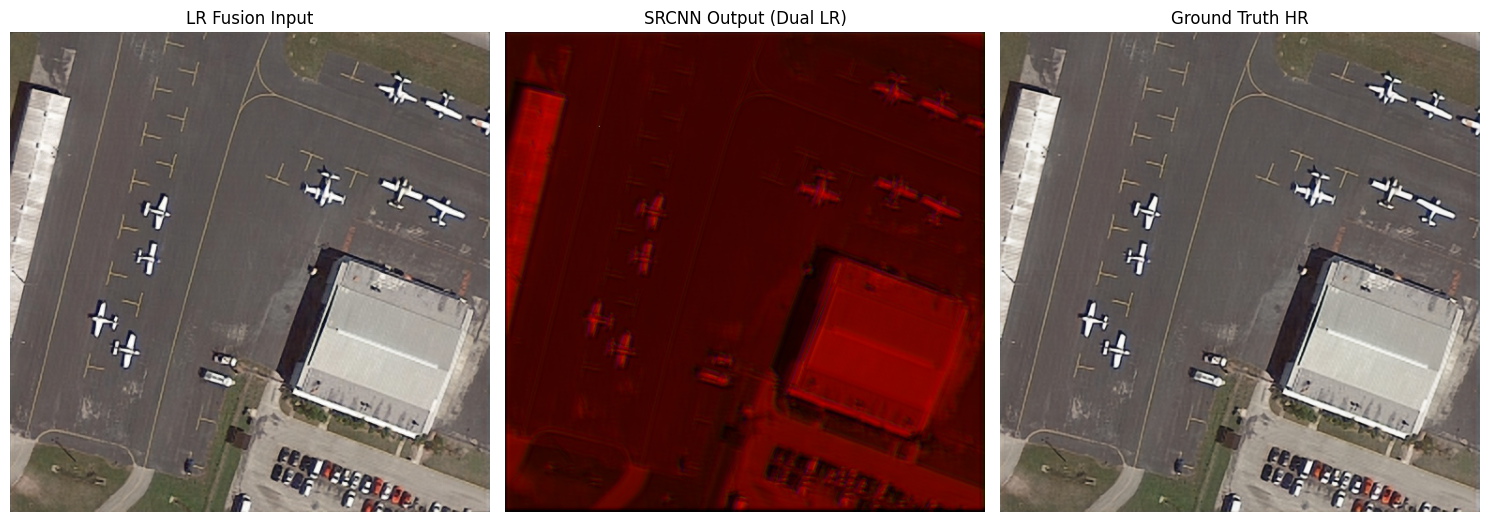

In [36]:

plt.figure(figsize=(15, 6))


plt.subplot(1, 3, 1)
plt.title("LR Fusion Input")
plt.imshow(fused_lr)
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title("SRCNN Output (Dual LR)")
plt.imshow(sr_dual)
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title("Ground Truth HR")
plt.imshow(hr_uint8)
plt.axis("off")

plt.tight_layout()
plt.show()


In [37]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import spearmanr, pearsonr
import numpy as np

In [38]:
X = np.array(vgg_scores).reshape(-1, 1)
y = np.array(psnr_scores)

In [39]:
lr_model = LinearRegression().fit(X, y)
lr_pred = lr_model.predict(X)

In [40]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42).fit(X, y)
rf_pred = rf_model.predict(X)

In [41]:
def evaluate_model(name, y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    sp, _ = spearmanr(y_true, y_pred)
    pr, _ = pearsonr(y_true, y_pred)
    print(f"\n{name} Results:")
    print(f"  RMSE:  {rmse:.4f}")
    print(f"  MAE:   {mae:.4f}")
    print(f"  Spearman: {sp:.4f}")
    print(f"  Pearson:  {pr:.4f}")

In [42]:
# Evaluate both models
evaluate_model("Linear Regression", y, lr_pred)
evaluate_model("Random Forest", y, rf_pred)


Linear Regression Results:
  RMSE:  0.0002
  MAE:   0.0002
  Spearman: 1.0000
  Pearson:  0.9992

Random Forest Results:
  RMSE:  0.0013
  MAE:   0.0011
  Spearman: 1.0000
  Pearson:  0.9964


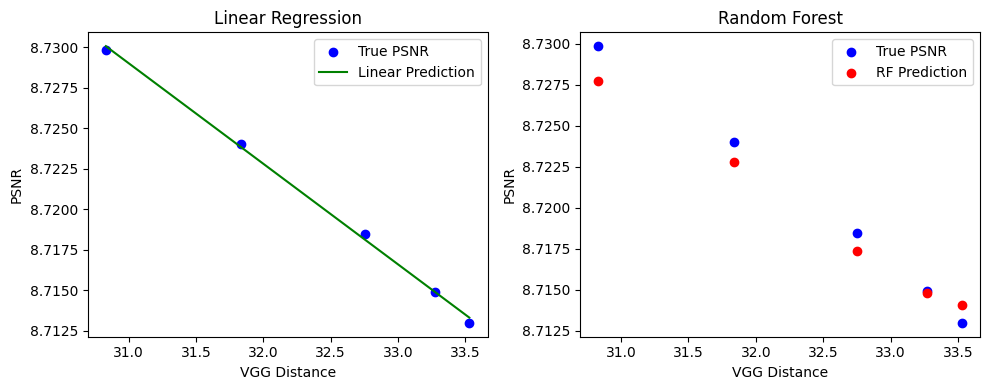

In [43]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.scatter(X, y, label="True PSNR", color='blue')
plt.plot(X, lr_pred, label="Linear Prediction", color='green')
plt.title("Linear Regression")
plt.xlabel("VGG Distance")
plt.ylabel("PSNR")
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(X, y, label="True PSNR", color='blue')
plt.scatter(X, rf_pred, label="RF Prediction", color='red')
plt.title("Random Forest")
plt.xlabel("VGG Distance")
plt.ylabel("PSNR")
plt.legend()

plt.tight_layout()
plt.show()
